In [1]:
import os

# 设置环境变量来指定使用的GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 仅使用0号GPU
import jax
from jax import numpy as np
from jax import vmap
import optax
import numpy as onp
from typing import Callable, Tuple
import sys
import argparse
# 设置环境变量
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.75'

# Network

In [2]:
"""
Nicholas M. Boffi
7/29/22

Neural networks for score-based transport modeling.
"""


import haiku as hk
import jax.numpy as np
import numpy as onp
from typing import Optional, Tuple, Callable, Union
import jax
from jax import vmap
from dataclasses import dataclass

###################################################################################################################
def construct_mlp_layers(
    n_hidden: int,
    n_neurons: int, # 每个隐藏层中的神经元（或单元）数量。
    act: Callable[[np.ndarray], np.ndarray], # 应用于每个隐藏层的激活函数。
    output_dim: int,
    residual_blocks: bool = True # 指示是否在MLP中使用残差连接。
) -> list:
    """Make a list containing the layers of an MLP.

    Args:
        n_hidden: Number of hidden layers in the MLP.
        n_neurons: Number of neurons per hidden layer.
        act: Activation function.
        output_dim: Dimension of the output.
        residual_blocks: Whether or not to use residual blocks.
    """
    layers = [] # 初始化一个空列表 layers，该列表将保存每层的配置。

    resid_act = lambda x: x + act(x)
    for layer in range(n_hidden):
        ## construct layer
        if layer == 0 or not residual_blocks:
            # 如果是第一层（layer == 0）或不使用残差块（not residual_blocks），则该层配置为简单的线性变换后跟激活函数
            layers = layers + [
                    hk.Linear(n_neurons),
                    act
                ]
        else:
            # 对于后续层（当 residual_blocks 为 True时），每层配置为线性变换后跟残差激活函数
            layers = layers + [
                    hk.Linear(n_neurons),
                    resid_act
                ]


    ## construct output layer
    layers = layers + [hk.Linear(output_dim)] # 在构造所有隐藏层后，函数添加输出层，这是一个到所需输出维度的线性变换
    return layers









###################################################################################################################
# 该函数用于构建两个score网络或潜在能量的神经网络模型，适用于不涉及相互作用粒子的简化系统。
def construct_score_network(
    d: int,
    n_hidden: int,
    n_neurons: int,
    act: Callable[[np.ndarray], np.ndarray],
    residual_blocks: bool = True,
    is_gradient: bool = False
) -> Tuple[Callable, Callable]:
    """Construct a score network for a simpler system
    that does not consist of interacting particles.

    Args:
        d: System dimension.
        n_hidden: Number of hidden layers in the network.
        n_neurons: Number of neurons per layer.
        act: Activation function.
        residual_blocks: Whether or not to use residual blocks.
        is_gradient: Whether or not to compute the score as the gradient of a potential.
    """
    output_dim = 1 if is_gradient else d 
    # 如果是梯度系统，就可以计算score + 能量， 就先定义能量，输出维度为 1；
    # 否则只计算score，输出维度为 d。
    net = lambda x: hk.Sequential(
        construct_mlp_layers(n_hidden, n_neurons, act, output_dim, residual_blocks)
    )(x)

    if is_gradient:
        # need to squeeze so the output of the potential is a scalar, rather than
        # a 1-dimensional array.
        potential = lambda x: np.squeeze(net(x)) # 定义 potential 函数，它通过 np.squeeze 确保输出为标量，适用于单输出网络。
        score = jax.grad(potential)
        return hk.without_apply_rng(hk.transform(score)), \
                hk.without_apply_rng(hk.transform(potential))
    else:
        return hk.without_apply_rng(hk.transform(net)), None


# Losses

In [3]:
"""
Nicholas M. Boffi
7/29/22

Loss functions for score-based transport modeling.
"""


import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as np
from typing import Tuple, Callable, Union, Optional
from jax import jit, vmap, value_and_grad
from jaxopt.linear_solve import solve_cg
from functools import partial
import haiku as hk
import optax


#######################################################################################################################
# 该函数用于计算一个初始潜在分布的梯度。
# 在这个具体的例子中，潜在分布被假设为一个各向同性（isotropic）的高斯分布（正态分布），具有均值 mu0 和标准差 sig0。
def grad_log_rho0(
    sample: np.ndarray,
    sig0: float,
    mu0: np.ndarray
) -> np.ndarray:
    """Compute the initial potential. Assumed to be an isotropic Gaussian."""
    return -(sample - mu0) / sig0**2

def rho0(sample: np.ndarray
    # sample: np.ndarray,
    # sig0: float = 1,
    # mu0: np.ndarray = 0
) -> np.ndarray:
    # sig0 = 1
    # mu0  = np.ones(d)*5
    """Compute the initial potential. Assumed to be an isotropic Gaussian."""
    return np.exp(-(sample - mu0)**2 / (2 * sig0**2))



#######################################################################################################################
@partial(jit, static_argnums=(4, 5, 7))
def init_loss(
    params: np.ndarray,
    samples: np.ndarray,
    sig0: float,
    mu0: np.ndarray,
    apply_score: Callable[[hk.Params, np.ndarray, Optional[float]], np.ndarray],
    time_dependent: bool = False, # 指示模型是否具有时间依赖性。
    frame_end: float = 0,
    nt: int = 0
) -> np.ndarray:
    """Compute the initial loss, assuming access to \nabla \log \rho0."""

    # grad_log_rho_evals = vmap(
    #     lambda sample:  D * grad_log_rho0(sample, sig0, mu0)
    # )(samples) # 使用 vmap 对 samples 中的每个样本应用 grad_log_rho0 函数，计算对数概率密度的梯度。
    grad_log_rho_evals = vmap(
        lambda sample:  1/2 * np.array([[sample[1], sigma_v * sample[1], 0],
                                            [sigma_v * sample[1], sigma_v**2 * sample[1] * (2 - rho**2), 0],
                                            [0, 0, sigma_m**2 * sample[2]]
                                            ]) @ grad_log_rho0(sample, sig0, mu0)
    )(samples) # 使用 vmap 对 samples 中的每个样本应用 grad_log_rho0 函数，计算对数概率密度的梯度。
    print(grad_log_rho_evals.shape)
    score_evals = vmap(
        lambda sample:   apply_score(params, sample)
    )(samples)

    # 函数 apply_score: 这个函数接受两个参数：params 和 sample。我们可以假设它根据某些参数 params 来评估或计算 sample 的“分数”或其他某种度量。
    # Lambda 函数: lambda sample: apply_score(params, sample) 是一个匿名函数，它采用单个参数 sample，并调用 apply_score 函数，将 params 作为第一个参数。这里的 params 可能是在外部定义的，由于 lambda 函数的作用域，它能够捕获并使用这个外部变量。
    # vmap 的使用: vmap 被用来自动向量化这个 lambda 函数。这意味着，vmap 将允许 apply_score 函数并行地处理 samples 数组中的每一个元素。
    # 执行 vmap: vmap(...)(samples) 这部分代码实际上是在调用 vmap 返回的向量化函数，并将 samples 作为输入。这里 samples 应该是一个数组或类似数组的结构，每个元素都是一个可以被 apply_score 处理的 "sample"。
    # 结果 score_evals: 最终的结果 score_evals 将是一个数组，其中包含对 samples 中每个样本应用 apply_score 函数得到的结果

    @jax.jit
    def levypart(sample):
        sample = np.array(sample)   # 应至少为一维数组
        print('print(sample.shape)', sample.shape)
        # 计算所有 lambdaj[j] * ri[i] 的组合
        lambdaj_ri_matrix = lambdaj[:, None, None] * Fr[None, :]  # [20, 50]
        # lambdaj_ri_matrix = np.expand_dims(lambdaj_ri_matrix, axis=2)
        # 扩展 sample
        print('print(lambdaj_ri_matrix.shape)',lambdaj_ri_matrix.shape)
        expanded_samples = sample - lambdaj_ri_matrix  # 假设 sample 是 [k,] 形状
        print('print(expanded_samples.shape)',expanded_samples.shape)
        all_scores = (jax.vmap(jax.vmap(rho0))(expanded_samples)).squeeze()
        print('print(all_scores.shape)',all_scores.shape)
        scores_sumj = np.mean(all_scores, axis=0)
        print('print(scores_sumj.shape)',scores_sumj.shape)
        scores_time_Fr = scores_sumj * Fr
        print('print(scores_time_Fr.shape)',scores_time_Fr.shape)
        scores = np.sum(scores_time_Fr, axis=1) * nu_J_r
        print('print(scores.shape) ', scores.shape) 
        
        """
            print(sample.shape) (3,)
            print(lambdaj_ri_matrix.shape) (20, 400, 3)
            print(expanded_samples.shape) (20, 400, 3)
            print(all_scores.shape) (20, 400, 3)
            print(scores_sumj.shape) (400, 3)
            print(scores_time_Fr.shape) (400, 3)
            print(scores.shape)  (400,)
        """

        # print('scores_sumj * ri * N_ri * 10 * sig_jump',(scores_sumj * ri * N_ri * 10 * sig_jump).shape,scores_sumj.shape)
        return np.mean(scores * 0.34 * 0.015 / 400) * (lambda0 + lambda1 * np.abs(sample[1]) + lambda2 * np.abs(sample[2])) / rho0(sample)

        
    # score = np.sum(   ( score_evals - (grad_log_rho_evals) )**2) \
    #         / np.sum((grad_log_rho_evals)**2)

    LEVYpart = vmap(levypart, in_axes=0)(samples)
    score = np.sum(   ( score_evals - (grad_log_rho_evals - LEVYpart) )**2) \
            / np.sum((grad_log_rho_evals-LEVYpart)**2)

    return score


  



#######################################################################################################################
@jit
def compute_grad_norm(
    grads: hk.Params
) -> float:
    """ Computes the norm of the gradient, where the gradient is input
    as an hk.Params object (treated as a PyTree)."""
    flat_params = ravel_pytree(grads)[0]
    # ravel_pytree 是一个函数，用于将 PyTree 结构的 grads 扁平化成一个一维数组。这使得可以对整个梯度向量进行数学操作。
    # [0] 是因为 ravel_pytree 返回一个元组，其中第一个元素是扁平化的数组，第二个元素通常是用于以后恢复原始结构的模板。
    return np.linalg.norm(flat_params) / np.sqrt(flat_params.size)
    # np.linalg.norm(flat_params) 计算扁平化梯度数组的 L2 范数（欧几里得范数）。
    # flat_params.size 获取扁平化数组的元素个数（即梯度向量的维度）。
    # 通过除以 np.sqrt(flat_params.size)，函数返回的是规范化的范数，这样做是为了使范数的计算与参数的数量无关，有助于更公平地比较不同大小模型的梯度大小。




#######################################################################################################################
@partial(jit, static_argnums=(2, 3))
def update(
    params: hk.Params, # 待优化的网络参数，类型为 hk.Params，这是 Haiku 库中用于表示参数的数据结构。
    opt_state: optax.OptState, # 优化器的状态，类型为 optax.OptState，这是 Optax 库中用于存储优化器状态（如动量等）的数据结构。
    opt: optax.GradientTransformation, # 优化器本身，类型为 optax.GradientTransformation，这是 Optax 库中用于定义梯度更新规则的对象。
    # opt = optax.adabelief(self.init_learning_rate)
    loss_func: Callable[[hk.Params], float],
    loss_func_args: Tuple = tuple(), # 传递给损失函数的额外参数，用于支持更灵活的函数签名。
) -> Tuple[hk.Params, optax.OptState, float, hk.Params]:
    """Update the neural network.

    Args:
        params: Parameters to optimize over.
        opt_state: State of the optimizer.
        opt: Optimizer itself.
        loss_func: Loss function for the parameters.
    """
    loss_value, grads = value_and_grad(loss_func)(params, *loss_func_args)
    
    # value_and_grad 是一个函数，它接受另一个函数（在这里是 loss_func），并返回一个新的函数，这个新函数同时计算原函数的值和关于参数的梯度。
    # 在这行代码中，使用解包操作符 * 将 loss_func_args 中的元素作为额外参数传递给 loss_func。
    updates, opt_state = opt.update(grads, opt_state, params=params) # 使用优化器的 update 方法计算参数更新和新的优化器状态。这通常基于当前梯度和先前的优化器状态进行计算。
    new_params = optax.apply_updates(params, updates) # 使用 optax.apply_updates，将计算得到的更新应用到当前参数上，产生新的参数。
    return new_params, opt_state, loss_value, grads # 返回更新后的参数、新的优化器状态、计算得到的损失值以及参数的梯度。这些输出对于进一步的分析和调试训练过程非常有用。


# Updata

In [4]:
"""
Nicholas M. Boffi
7/29/22

Updates to parameters and particles for score-based transport modeling.
"""

from jax import jit, vmap
import jax
from functools import partial
import jax.numpy as np
import numpy as onp
import haiku as hk
from typing import Callable, Tuple, Union
# from tqdm.auto import tqdm as tqdm


#######################################################################################################################
@partial(jit, static_argnums=(5, 6)) 
# 参数 static_argnums 指定第 5 和第 6 个参数（从 0 开始计数，即 forcing 和 apply_score）在函数调用时应该是静态的，
# 这意味着这些函数的引用在多次调用中不应改变，以便于 JIT 编译器优化。
# 执行一个前向欧拉步骤来更新粒子的位置。
def update_particles(
    particle_pos: np.ndarray,
    t: float,
    params: hk.Params,
    D: Union[np.ndarray, float], # 扩散系数，可以是一个数值或者一个与粒子位置同形状的数组。 Union 是用来表现变量可能拥有的不同类型的一个联合。
    dt: float,
    forcing: Callable[[np.ndarray, float], np.ndarray], # 根据给定的粒子位置和时间计算外力。
    apply_score: Callable[[hk.Params, np.ndarray], np.ndarray], # 用模型参数和粒子位置计算score.
    mask: np.ndarray = None
) -> np.ndarray:
    """Take a forward Euler step and update the particles."""
    
    if mask is not None:
        score_term = -mask * apply_score(params, particle_pos)
    else:
        score_term = -apply_score(params, particle_pos)

    return particle_pos + dt*(forcing(particle_pos, t) + score_term)
    # 它将原始位置与由外力项 forcing(particle_pos, t) 和得分项 score_term 的和乘以时间步长 dt 的结果相加。
    # 这是一个典型的前向欧拉积分步骤，用于将粒子向其动力学方向移动。




#######################################################################################################################
@partial(jit, static_argnums=(5, 6))
# 使用 Euler-Maruyama 方法来更新粒子位置，这通常涉及到一些随机性（噪声）的引入。
def update_particles_EM(
    particle_pos: np.ndarray,
    t: float,
    D_sqrt: Union[np.ndarray, float], # 扩散系数的平方根，可以是一个数值或者一个与粒子位置数组相同形状的数组。
    dt: float,
    key: np.ndarray, # 用于生成随机数的密钥，此参数与 JAX 的随机数生成机制相关。
    forcing: Callable[[np.ndarray, float], np.ndarray],
    noisy: bool = True,
    mask: np.ndarray = None,
) -> np.ndarray:
    """Take a step forward via Euler-Maruyama to update the particles."""

    if noisy:
        noise = np.sqrt(2*dt) * jax.random.normal(key, shape=particle_pos.shape)
        if mask is not None:
            brownian = -D_sqrt * mask * noise
        else:
            brownian = -D_sqrt * noise

        return particle_pos + dt*forcing(particle_pos, t) + brownian
    else:
        return particle_pos + dt*forcing(particle_pos, t)






#######################################################################################################################
# 使用 Euler-Maruyama 方法从一组初始条件（x0s）生成随机轨迹
def rollout_EM_trajs(
    x0s: np.ndarray,
    nsteps: int,
    t0: float,
    dt: float,
    key: np.ndarray,
    forcing: Callable[[np.ndarray, float], np.ndarray],
    D_sqrt: Union[np.ndarray, float],
    noisy: bool = True
) -> np.ndarray:
    """Given a set of initial conditions, create a stochastic trajectory 
    via Euler-Maruyama. Useful for constructing a baseline against which to compare
    the moments.

    Args:
    ------
    x0s: Initial condition. Dimension = n x d where n is the number of samples 
         and d is the dimension of the system.
    nsteps: Number of steps of Euler-Maruyama to take.
    t0: initial time.
    dt: Timestep.
    key: jax PRNG key.
    forcing: Forcing to apply to the particles.
    D_sqrt: Square root of the diffusion matrix.
    """
    n, d = x0s.shape
    trajs = onp.zeros((nsteps+1, n, d)) # 创建一个用于存储粒子轨迹的零数组。数组的形状为 (nsteps+1, n, d)，即存储从初始时间到最后一个时间步的粒子位置。
    trajs[0] = x0s
    step_sample = \
            lambda sample, t, key: update_particles_EM(sample, t, D_sqrt, 
                                                       dt, key, forcing, noisy)
    step_samples = vmap(step_sample, in_axes=(0, None, 0), out_axes=0)

    
    for curr_step in tqdm(range(nsteps)):
        t = t0 + curr_step*dt
        keys = jax.random.split(key, num=n) # 使用 JAX 的随机功能，将密钥分割成 n 个新的随机密钥，以便为每个粒子生成随机数。
        trajs[curr_step+1] = step_samples(trajs[curr_step], t, keys)
        key = keys[-1] # 更新使用的主密钥为生成的密钥中的最后一个，以便在下一次迭代中使用。

    return trajs, key # 返回存储了所有时间步粒子位置的轨迹数组和最后的密钥状态


# Rollouts

In [5]:
"""
Nicholas M. Boffi
8/4/22

Training loops for score-based transport modeling.
"""


from jax import jit, vmap
from jax.tree_util import tree_map
import jax
from functools import partial
import jax.numpy as np
import numpy as onp
import haiku as hk
from typing import Callable, Tuple, Union
# import losses
# import updates
import optax
import dill as pickle
import time
from tqdm import tqdm
from jaxlib.xla_extension import Device

Time = float


def fit_initial_condition(
    n_max_opt_steps: int, # 最大优化步骤数。
    ltol: float, # 损失值的容忍度，当损失值低于此阈值时优化停止。
    params: hk.Params, 
    sig0: float, # 目标初始条件的标准差。
    mu0: np.ndarray,
    score_network: Callable[[hk.Params, np.ndarray], np.ndarray],
    opt: optax.GradientTransformation,
    opt_state: optax.OptState,
    samples: np.ndarray,
    time_dependent: bool = False,
    frame_end: float = 0,
    nt: int = 0
) -> hk.Params:
    """Fit the score for the initial condition.

    Args:
        n_opt_steps: Number of optimization steps before the norm of the gradient 
                     is checked.
        gtol: Tolerance on the norm of the gradient.
        ltol: Tolerance on the relative error.
        params: Parameters to optimize over.
        sig0: Standard deviation of the target initial condition.
        mu0: Mean of the target initial condition.
        score_network: Function mapping parameters and a sample to the network output.
        opt: Optimizer.
        opt_state: State of the optimizer.
        samples: Samples to optimizer over.
    """
    # 在 haiku 中，你首先定义一个模型的前向传播函数，并使用 hk.transform 转换这个函数，从而生成一个 Transformed 对象。这个对象包含两个主要的方法：init 和 apply。

    # init：用于初始化模型参数。
    # apply：用于在给定输入和参数的情况下运行模型。
    
    apply_score = score_network.apply # 这行代码提取 score_network 的 apply 方法，执行前向传递。
    loss_func = lambda params: \
            init_loss(params, samples, sig0, mu0, apply_score, 
                             time_dependent, frame_end, nt)

    loss_val = np.inf
    try:
        with tqdm(range(n_max_opt_steps)) as pbar:
            pbar.set_description("Initial optimization")
            for curr_step in pbar:
                try:
                    params, opt_state, loss_val, grads = update(params, opt_state, opt, loss_func)
                    pbar.set_postfix(loss=loss_val)
                    if loss_val < ltol:
                        break
                except Exception as e:
                    print(f"Error at step {curr_step}: {e}")
                    break
    except Exception as e:
        print(f"Error initializing the progress bar: {e}")

    return params


# Drifts


In [6]:
"""
Nicholas M. Boffi
7/29/22

Drift terms for score-based transport modeling.
"""


from jax import vmap
from jax.lax import stop_gradient
import jax.numpy as np
from typing import Callable, Tuple



############################################################################################################################
def hyf_exapmle1(
    x: np.ndarray,
    t: float,
    # gamma: float
    kappa: float,
    eta: float
) -> np.ndarray:
    del t
    return (kappa * (eta - x) )

############################################################################################################################
def hyf_exapmle2(
    x: np.ndarray,
    t: float,
    # gamma: float
    kappa: float,
    eta: float
) -> np.ndarray:
    del t
    return (kappa * x - eta * x**3 )

############################################################################################################################
def hyf_exapmle3(
    svm: np.ndarray,
    t: float,
    gamma: float,
    delta: float,
    Jbar: float,
    kappa_v: float,
    kappa_m: float,
    alpha_m: float,
    lambda0: float,
    lambda1: float,
    lambda2: float,
    sigma_v: float,
    sigma_m: float,
    rho: float
) -> np.ndarray:
    del t
    s,v,m = svm
    return np.array([gamma - delta - v/2 - (lambda0 + lambda1 * np.abs(v) + lambda2 * np.abs(m))*Jbar, kappa_v*(m - v), kappa_m *(alpha_m - m)]) - 1/2 * np.array([sigma_v, sigma_v**2*(2-rho**2),sigma_m**2])



# SBTM-SIM


In [7]:
"""
Base class for score-based transport modeling.

Nicholas M. Boffi
10/27/22
"""


from dataclasses import dataclass
from typing import Callable, Tuple, Union
import haiku as hk
import jax
import numpy as onp
from jaxlib.xla_extension import Device
import optax

# import networks
# import rollouts

State = onp.ndarray
Time = float


@dataclass
# @dataclass 是一个装饰器，用于自动化一些用于存储数据的类的常见模式。这个装饰器来自标准库中的 dataclasses 模块，主要目的是让类更加简洁易读。
class SBTMSim:
    """
    Base class for all SBTM simulations.
    Contains simulation parameters common to all SBTM approaches.
    """
    # initial condition fitting
    n_max_init_opt_steps: int
    init_learning_rate: float
    init_ltol: float
    sig0: float
    mu0: onp.ndarray

    # system parameters
    drift: Callable[[State, Time], State]
    force_args: Tuple
    amp: Callable[[Time], float]
    freq: float
    dt: float
    D: onp.ndarray
    D_sqrt: onp.ndarray
    n: int
    d: int
    N: int

    # timestepping
    ltol: float
    gtol: float
    n_opt_steps: int
    learning_rate: float

    # network parameters
    n_hidden: int
    n_neurons: int
    act: Callable[[State], State]
    residual_blocks: bool
    interacting_particle_system: bool

    # general simulation parameters
    key: onp.ndarray
    params_list: list
    all_samples: dict

    # output information
    output_folder: str
    output_name: str


    def __init__(self, data_dict: dict) -> None:
        self.__dict__ = data_dict.copy()
    # 初始化方法，直接将传入的字典复制到类的属性中。

    def initialize_forcing(self) -> None:
        self.forcing = lambda x, t: self.drift(x, t, *self.force_args)
    # 初始化外力函数。这里 forcing 是一个 lambda 函数，接受状态 x 和时间 t，调用定义的 drift 函数。

    def initialize_network_and_optimizer(self) -> None:
        """Initialize the network parameters and optimizer."""
        if self.interacting_particle_system:
            self.score_network, self.potential_network = \
                    construct_interacting_particle_system_network(
                            self.n_hidden, 
                            self.n_neurons, 
                            self.N, 
                            self.d, 
                            self.act, 
                            self.residual_blocks
                        )

            example_x = onp.zeros(self.N*self.d) # 初始化一个示例输入数组 example_x，用于网络初始化。其大小是粒子总数乘以维度。
        else:
            self.score_network, self.potential_network= \
                construct_score_network(
                    self.d,
                    self.n_hidden,
                    self.n_neurons,
                    self.act,
                    is_gradient=False
                )
            
            example_x = onp.zeros(self.d) # 对于非交互粒子系统，初始化的示例输入数组 example_x 只与维度有关。
        self.key, sk = jax.random.split(self.key) # 使用 JAX 的随机数生成功能，分割随机数种子 key。这是为了确保随机性的可控制和重现性。
        init_params = self.score_network.init(self.key, example_x) # 使用网络的初始化方法（这通常是由 Haiku 提供的）和示例输入 examplex_x 来初始化网络参数。 (基于这个样本的尺寸来确定你各层的参数尺寸)
        self.params_list = [init_params] # 将初始化的参数存储到 params_list 中。


        network_size = jax.flatten_util.ravel_pytree(init_params)[0].size # 使用了 JAX 的 jax.flatten_util.ravel_pytree 函数把复杂的参数树（pytree）“展平”成一个简单的一维数组
        print(f'Number of parameters: {network_size}')
        print(f'Number of parameters needed for overparameterization: ' \
                + f'{self.n*example_x.size}')

        # set up the optimizer
        self.opt = optax.radam(self.learning_rate) # 使用 Optax 库中的 RAdam（Rectified Adam）优化器初始化优化器，并设置学习率。
        self.opt_state = self.opt.init(init_params) # 使用优化器的初始化方法和网络参数初始化优化器的状态。

        # set up batching for the score
        self.batch_score = jax.vmap(self.score_network.apply, in_axes=(None, 0)) # 使用 JAX 的 vmap 函数设置批量评分功能。这允许并行处理多个输入，提高计算效率。

    def fit_init(self, cpu: Device, gpu: Device) -> None:
        """Fit the initial condition."""
        # draw samples
        samples_shape = (self.n, self.N*self.d) # 确定样本的形状，self.n 是样本数量，self.N*self.d 表示每个样本的维度。
        init_samples = self.sig0*onp.random.randn(*samples_shape) + self.mu0[None, :] # init_samples 通过从正态分布中抽取样本并按照特定的均值 (self.mu0) 和标准差 (self.sig0) 进行调整来生成初始样本。

        # set up optimizer
        init_params = jax.device_put(self.params_list[0], gpu) # init_params 从 params_list 中获取第一组参数，并使用 jax.device_put 确保这些参数被加载到 gpu 设备上。
        opt = optax.adabelief(self.init_learning_rate) # 初始化一个 AdaBelief 优化器 (optax.adabelief)，此优化器适用于深度学习应用中的稳健优化。
        opt_state = opt.init(init_params)

        init_params = fit_initial_condition(
                            self.n_max_init_opt_steps,
                            self.init_ltol,
                            init_params,
                            self.sig0,
                            self.mu0,
                            self.score_network,
                            opt,
                            opt_state,
                            init_samples
                        )


        self.params_list = [jax.device_put(init_params, device=cpu)] # 更新 self.params_list，其中包含了优化后的参数，这次使用 jax.device_put 确保参数被转移到 cpu 设备。
        self.all_samples = {'SDE': [init_samples], 'learned': [init_samples]}


# SBTM-SEQUENTIAL

In [8]:
"""
Code for sequential SBTM.

Nicholas M. Boffi
10/27/22
"""


from dataclasses import dataclass
import jax
import jax.numpy as np
from jax import vmap
import numpy as onp
# from tqdm.auto import tqdm as tqdm
import dill as pickle
import time
from jaxlib.xla_extension import Device
from haiku import Params
from typing import Tuple


# import sbtm_sim
# import updates
# import losses
# from sbtm_analysis import compute_entropy_rate


@dataclass
class SequentialSBTM(SBTMSim): # 它继承自一个模拟框架 sbtm_sim.SBTMSim
    n_time_steps: int
    use_SDE: bool
    use_ODE: bool
    save_fac: int 
    store_fac: int # 整数，控制数据保存和存储的频率。
    means: dict
    covs: dict # 字典，用于存储模拟过程中计算的均值和协方差。
    entropies: list # 列表，用于记录熵的变化。
    mask: np.ndarray


    def setup_loss(self):
        """Define the loss function. """
        raise NotImplementedError("Please implement in the inheriting class.") # 类比：强制任何继承 Animal 的类（如 Dog 和 Cat）实现自己版本的 make_sound() 方法， 否则就报错


    
    def setup_loss_fn_args(self, gpu: Device) -> Tuple:
        """Define the arguments to the loss function other than parameters."""
        raise NotImplementedError("Please implement in the inheriting class.")
        

    def setup_batched_steppers(self):
        """Construct convenience functions to step the particles."""
        self.step_learned = vmap(
                lambda params, t, sample: update_particles(
                    sample, 
                    t, 
                    params, 
                    self.D, 
                    self.dt,  
                    self.forcing, 
                    self.score_network.apply,
                    self.mask
                ),
                in_axes=(None, None, 0),
                out_axes=0
        )

        self.step_SDE = vmap(
                lambda t, sample, key: update_particles_EM(
                    sample, 
                    t, 
                    self.D_sqrt, 
                    self.dt, 
                    key,  
                    self.forcing,
                    True,
                    self.mask
                ),
                in_axes=(None, 0, 0),
                out_axes=0
        )

    # 更新并保存 SDE 和 ODE 样本
    def step_samples(
        self,
        step,
        params: Params,
        t: float,
        samples: np.ndarray,
        SDE_samples: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Step and save both the SDE and ODE samples."""
        # step learned and SDE particles
        samples = self.step_learned(params, t, samples)
        keys = jax.random.split(self.key, num=self.n)
        SDE_samples = self.step_SDE(t, SDE_samples, keys)
        # print('!!!!!!!!!!SDE_samples.s',SDE_samples.shape,keys.shape)
        self.key = keys[-1]

        # save new samples
        if (step+1) % self.store_fac == 0:
            self.all_samples['learned'].append(onp.array(samples))
            self.all_samples['SDE'].append(onp.array(SDE_samples))

        return samples, SDE_samples


    def setup_learning_samples(
        self,
        samples: np.ndarray,
        SDE_samples: np.ndarray
    ) -> Tuple[np.ndarray]:
        """Set up samples to optimize over."""
        if self.use_ODE and self.use_SDE:
            opt_samples = (np.vstack((samples, SDE_samples)),)
        elif self.use_ODE:
            opt_samples = (samples,)
        elif self.use_SDE:
            opt_samples = (SDE_samples,)
        else:
            raise ValueError('Need to specify learning from ODE or SDE.')

        return opt_samples


    def compute_moments_and_entropy_production(
        self,
        params: Params,
        t: float,
        samples: np.ndarray, 
        SDE_samples: np.ndarray
    ) -> None:
        ## entropy
        self.entropies.append(
                compute_entropy_rate(samples, t, params, self.D, self.forcing, 
                                     self.score_network, noise_free=False, div=True)
            )

        ## moments
        self.means['SDE'].append(np.mean(SDE_samples, axis=0))
        self.covs['SDE'].append(np.cov(SDE_samples, rowvar=False))

        self.means['learned'].append(np.mean(samples, axis=0))
        self.covs['learned'].append(np.cov(samples, rowvar=False))


    def solve_fpe_sequential(self, cpu: Device, gpu: Device):
        # set up some convenience variables
        self.setup_loss()
        self.setup_batched_steppers()
        nt = len(self.params_list) - 1

        # move needed data to the GPU for speed.
        params = jax.device_put(self.params_list[-1], gpu) # 将参数列表中的最后一个参数集迁移到 GPU 上，以加速计算。
        opt_state = jax.device_put(self.opt_state, gpu)
        samples = jax.device_put(self.all_samples['learned'][-1], gpu) # 将学习得到的样本的最后一批迁移到 GPU。
        SDE_samples = jax.device_put(self.all_samples['SDE'][-1], gpu) # 将 SDE 样本的最后一批迁移到 GPU。

        # store the initial moments and entropy.
        # if nt == 0: # 如果 nt 是 0（即是第一次执行），则计算初始时刻的统计矩和熵产生。
        #     self.compute_moments_and_entropy_production(params, t=0, 
        #                                                 samples=samples, 
        #                                                 SDE_samples=SDE_samples)

        ## output progress bar
        with tqdm(range(self.n_time_steps)) as pbar: #使用 tqdm 库创建一个进度条，用于显示时间步进的进度。
            for step in pbar:
                t = (nt*self.store_fac + step)*self.dt
                pbar.set_description(f"Dynamics: t={t:.3f}") # 遍历每个时间步。计算当前的时间 t，并更新进度条的描述。

                samples, SDE_samples = self.step_samples(step, params, t, samples, SDE_samples) # 在当前时间步上，更新样本和 SDE 样本。
                opt_samples = self.setup_learning_samples(samples, SDE_samples)

                ## perform the optimization
                loss_value, grad_norm = np.inf, np.inf
                num_steps_taken = 0
                while (grad_norm > self.gtol):
                    for curr_opt_step in range(self.n_opt_steps): # 循环执行优化步骤，计算损失函数的参数，记录时间。
                        loss_func_args = opt_samples + self.setup_loss_fn_args(gpu)
                        # print(loss_func_args)
                        start_time = time.time()
                        params, opt_state, loss_value, grads \
                                = update(
                                        params, 
                                        opt_state, 
                                        self.opt, 
                                        self.loss_func, 
                                        loss_func_args
                                    )
                        end_time = time.time()

                    grad_norm = compute_grad_norm(grads)
                    pbar.set_postfix(
                        loss=loss_value, ltol=self.ltol,
                        grad_norm=grad_norm, gtol=self.gtol,
                        step_time=end_time-start_time
                    ) # 更新进度条的后缀信息。

                # if (step+1) % self.store_fac == 0:
                #     self.params_list.append(jax.device_put(params, cpu))
                #     self.compute_moments_and_entropy_production(params, t, samples, SDE_samples)
                # 如果达到存储频率，将参数迁回 CPU 并保存，计算当前参数下的统计矩和熵产。
                if (step+1) % self.save_fac == 0:
                    self.save_data()
                # 如果达到保存频率，保存数据。
        self.save_data()


    def save_data(self):
        data = vars(self).copy()
        # vars(self) 返回一个包含对象 self 实例的所有属性和值的字典。
        # 调用 .copy() 方法创建这个字典的浅拷贝，以确保在保存数据的过程中原始数据不被更改。
        
        pickle.dump(data, open(f'{self.output_folder}/{self.output_name}', 'wb'))
        # 使用 Python 的 pickle 模块来序列化 data 对象。pickle.dump 函数用于将对象序列化并写入一个文件。
        # open(f'{self.output_folder}/{self.output_name}', 'wb') 打开一个文件用于写入，路径由 self.output_folder 和 self.output_name 属性定义，'wb' 表示“写入二进制”模式。
        # 序列化的数据被写入指定的文件中，文件路径由对象的 output_folder 和 output_name 属性组成。




@dataclass
class DenoisingSequentialSBTM(SequentialSBTM):
    noise_fac: float # noise_fac 是一个类属性，用于在计算去噪损失时缩放噪声。它是一个决定添加到样本中噪声幅度的因子。

    def setup_loss(self):
        @jax.jit
        def score_for_sample(params, sample):
            print('print(sample.shape)',sample.shape)
            # 计算所有 lambdaj[j] * ri[i] 的组合
            lambdaj_ri_matrix = lambdaj[:, None, None] * Fr[None, :]  # [20, 400, 3]
            print('print(lambdaj_ri_matrix.shape)',lambdaj_ri_matrix.shape)
            # 扩展 sample
            expanded_samples = sample + lambdaj_ri_matrix  # 假设 sample 是 [k,] 形状
            print('print(expanded_samples.shape)',expanded_samples.shape)
            # 使用 vmap 向量化评分网络的应用
            def apply_network(exp_sample):
                return self.score_network.apply(params, exp_sample)

            all_scores = (jax.vmap(jax.vmap(apply_network))(expanded_samples)).squeeze()
            
            print('print(all_scores.shape,ri.shape)',all_scores.shape)
            # 加权得分
            scores_sumj = np.mean(all_scores, axis=0)
            scores_time_Fr = scores_sumj * Fr
            print('print(scores_time_Fr.shape)',scores_time_Fr.shape)
            scores = np.sum(scores_time_Fr, axis=1) * nu_J_r
            print('print(scores.shape) ', scores.shape) 
            """ 
            print(sample.shape) (3,)
            print(lambdaj_ri_matrix.shape) (20, 400, 3)
            print(expanded_samples.shape) (20, 400, 3)
            print(all_scores.shape,ri.shape) (20, 400, 3)
            print(scores_time_Fr.shape) (400, 3)
            print(scores.shape)  (400,)
            """
            return np.mean(scores * 0.34 * 0.015 / 400) * (lambda0 + lambda1 * np.abs(sample[1]) + lambda2 * np.abs(sample[2]))
            
        def sample_denoising_loss(
            params: Params,
            sample: np.ndarray,
            noise: np.ndarray,
        ) -> float: # 这是一个定义为计算单个样本的去噪损失的嵌套函数。它使用模型的参数 (params)、数据集的样本 (sample) 和一个噪声数组 (noise)。
            """
            Compute the denoising loss on a single sample, using antithetic sampling
            over the noise for variance reduction.
            """
            loss = 0
            for sign in [-1, 1]:
                perturbed_sample = sample + self.noise_fac*sign*noise
                score = self.mask* self.score_network.apply(params, perturbed_sample)
                # score = self.mask*np.array([[perturbed_sample[1], sigma_v * perturbed_sample[1], 0],
                #                             [sigma_v * perturbed_sample[1], sigma_v**2 * perturbed_sample[1] * (2 - rho**2), 0],
                #                             [0, 0, sigma_m**2 * perturbed_sample[2]]
                #                             ]) @ self.score_network.apply(params, perturbed_sample)

                print('self.score_network.apply(params, perturbed_sample)',(self.score_network.apply(params, perturbed_sample)).shape)
                loss += np.sum(self.noise_fac*score**2 +  sign* np.array([[perturbed_sample[1], sigma_v * perturbed_sample[1], 0],
                                                                    [sigma_v * perturbed_sample[1], sigma_v**2 * perturbed_sample[1] * (2 - rho**2), 0],
                                                                    [0, 0, sigma_m**2 * perturbed_sample[2]]
                                                                    ]) @ score*noise)
            # 使用对偶采样计算损失，通过添加和减去噪声 (sign 为 -1 和 1)，以减少损失估计的方差。
            # perturbed_sample 是通过噪声（按 noise_fac 缩放）调整的样本。
            # score 通过将得分网络应用于扰动样本来计算，并通过 self.mask 进行掩码处理。
            # 损失计算包括得分的平方项和得分与噪声的交叉项。

            return np.squeeze(loss / 2) # 对两个对偶样本的单个样本损失进行平均，并压缩以移除任何多余的维度。
        # self.loss_func = lambda params, samples, noise: np.mean(vmap(sample_denoising_loss, in_axes=(None, 0, 0))(params, samples, noise)) 
        self.loss_func = lambda params, samples, noise: np.mean(vmap(sample_denoising_loss, in_axes=(None, 0, 0))(params, samples, noise))  +2 * self.noise_fac* np.mean(vmap(score_for_sample, in_axes=(None, 0))(params, samples))
        print(self.loss_func)
        
        # self.loss_func 定义为一个 lambda 函数，计算一批样本的平均损失。 使用 vmap 将 sample_denoising_loss 向量化到样本和噪声的批次上，允许并行计算损失。

        if self.use_SDE and self.use_ODE:
            self.n_train_samples = 2*self.n
        else:
            self.n_train_samples = self.n


    def setup_loss_fn_args(self, gpu: Device) -> Tuple:
        """Set up noise arguments for the loss function. """
        noises = onp.random.randn(self.n_train_samples, self.d*self.N)
        loss_func_args = (jax.device_put(noises, gpu),)
        return loss_func_args



In [9]:
print(jax.devices())
gpu = jax.devices('gpu')[0]
cpu = jax.devices('cpu')[0]


######## Configuation Parameters #########
d      = 3
D      = 2
D_sqrt = onp.sqrt(D)
mask   = onp.array([1, 1, 1])
dt     = 1e-3
tf     = 1
n      = 4000
n_time_steps = int(tf / dt)
store_fac = 5


## configure random seed
repeatable_seed = False
if repeatable_seed:
    key = jax.random.PRNGKey(42)
    onp.random.seed(42)
else:
    key = jax.random.PRNGKey(onp.random.randint(10000))


## set up forcing parameters

# Parameters (r, δ, Kv, km, αm, σv, σm, ρ)
gamma = 0.04
delta = 0.015
kappa_v = 3.1206
kappa_m = 3.3168
alpha_m = 0.1125
sigma_v = 0.394
sigma_m = 0.0835
rho = -0.688

# Additional parameters (λ0, λ1, λ2)
lambda0 = 2.096
lambda1 = 21.225
lambda2 = 0

# Parameters (μJ, σJ, μJV)
mu_J = -0.012
sigma_J = 0.043
mu_J_V = 0.002
Jbar = np.exp (mu_J + sigma_J**2/2) -1

drift      = hyf_exapmle3
force_args = (gamma, delta, Jbar, kappa_v, kappa_m, alpha_m, lambda0, lambda1, lambda2, sigma_v, sigma_m, rho, )


## initial distribution parameters
sig0 = 1
mu0  = np.ones(d)*5

### setup optimizer
init_learning_rate = 1e-3
init_ltol = 1e-6
ltol = np.inf
gtol = 0.5
n_opt_steps = 25
n_max_init_opt_steps = int(1e4)


### Set up neural network
n_hidden = 3
n_neurons = 32
act = jax.nn.swish
residual_blocks = False

### output data
base_folder   = 'lcy/sbtm-levy/experiments/result'
system_folder = 'example3'
output_folder = f'{base_folder}/{system_folder}'

#######################################################################################################################
# 创建点的范围
from scipy.stats import norm
N = 20
# 生成第一维：从-1到1的50个等间距的点
dim1 = np.linspace(-0.17, 0.17, N)

# 生成第二维：从0到2的50个等间距的点
dim2 = np.linspace(0, 0.015, N)

# 使用meshgrid获取所有可能的点组合
grid_dim1, grid_dim2 = np.meshgrid(dim1, dim2)

# 将网格数据变形为一列，每个点对应一个向量
vectors_2d = np.column_stack((grid_dim1.ravel(), grid_dim2.ravel()))

# 创建一个全为0的数组作为第三维
zero_dimension = np.zeros(vectors_2d.shape[0])

# 将这个0维数组添加到已有的二维向量数组中，形成三维向量数组
ri = np.column_stack((vectors_2d, zero_dimension))
Fr = ri
Fr = Fr.at[:, 0].set(np.log(Fr[:, 0] + 1))

from scipy.stats import lognorm
nu_J_r = lognorm.pdf(ri[:, 0]+1, s=sigma_J, scale=np.exp(mu_J)) *  1/mu_J_V * np.exp(-1/mu_J_V * ri[:, 1])
print('print(nu_J_r.shape)',nu_J_r.shape)
print('print(Fr.shape)',Fr.shape)

lambdaj = np.linspace(0, 1, 20)
print('print(lambdaj.shape)',lambdaj.shape)
# 正态分布权重 N(ri)


print("lambdaj[:, None] * ri[None, :]",(lambdaj[:, None, None] * Fr[None, :]).shape)
lambdaj = np.array(lambdaj)  # 应为 [20,]

[CudaDevice(id=0)]


2024-10-06 18:59:28.400418: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


print(nu_J_r.shape) (400,)
print(Fr.shape) (400, 3)
print(lambdaj.shape) (20,)
lambdaj[:, None] * ri[None, :] (20, 400, 3)


(400, 3)
5.2452087e-06


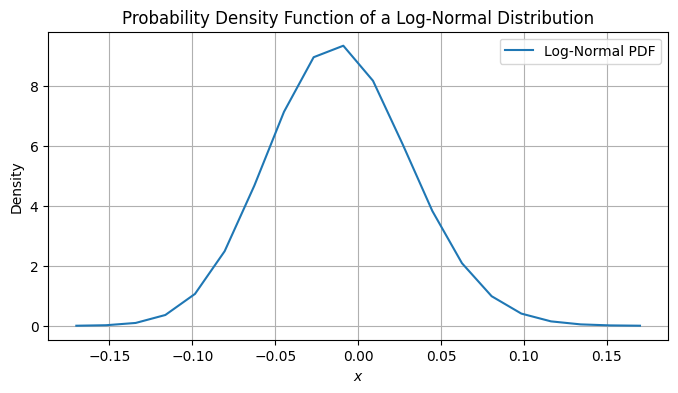

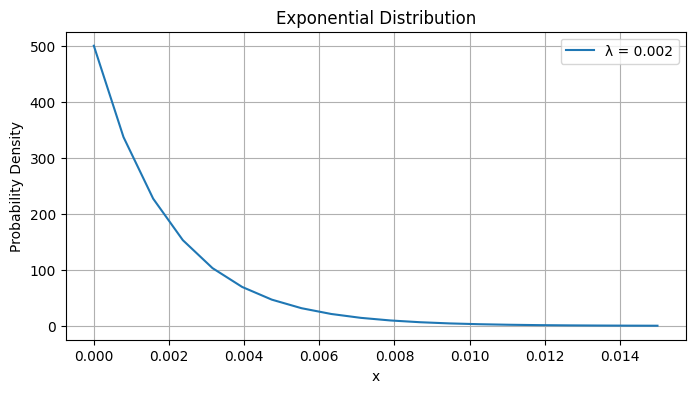

In [10]:

Fr = Fr.at[:, 0].set(np.log(Fr[:, 0] + 1))
print(Fr.shape)


###################################################################################

# 计算对数正态分布的PDF
# 注意，scipy的lognorm是按s=sigma, scale=exp(mu)来参数化的
# 使用 scipy 的 lognorm 计算 PDF
pdf_values = lognorm.pdf(dim1+1, s=sigma_J, scale=np.exp(mu_J))
# print(pdf_values)

# 定义正确参数顺序的对数正态 PDF 函数
def log_normal_pdf(x, mu, sigma):
    x = x + 1
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))

# 使用自定义函数计算 PDF
pdf_values_1 = log_normal_pdf(dim1, mu_J, sigma_J)
# print(pdf_values_1)

# 比较两种方法的结果
print((pdf_values - pdf_values_1).max())


###################################################################################

import matplotlib.pyplot as plt
from scipy.stats import lognorm
# 生成一些正值数据
r = np.linspace(-0.17, 0.17, 100).reshape(-1, 1)

# 计算PDF
pdf_values = lognorm.pdf(dim1+1, s=sigma_J, scale=np.exp(mu_J))

# 绘制PDF
plt.figure(figsize=(8, 4))
plt.plot(dim1, pdf_values, label="Log-Normal PDF")
plt.title("Probability Density Function of a Log-Normal Distribution")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


# 生成x的值
x = dim2
# 计算概率密度函数
pdf = 1/mu_J_V * np.exp(-1/mu_J_V * x)

# 绘图
plt.figure(figsize=(8, 4))
plt.plot(x, pdf, label=f'λ = {mu_J_V}')
plt.title('Exponential Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import os

# 定义你的目录路径
directory = 'lcy/sbtm-levy/experiments/result/example3'

# 使用 os.makedirs 来确保目录存在，exist_ok=True 表示如果目录已存在则忽略
os.makedirs(directory, exist_ok=True)

# 现在你可以安全地保存文件到这个目录
# file_path = os.path.join(directory, 'lr=0.01_nf=0.1.npy')
# 假设你要保存的 numpy 数组为 data_array
# numpy.save(file_path, data_array)

In [12]:
def construct_simulation(
    learning_rate: float,
    noise_fac: float,
    name_str: str
):
    output_name = f'{name_str}.npy'
    sim = DenoisingSequentialSBTM(
        n_max_init_opt_steps=n_max_init_opt_steps,
        init_learning_rate=init_learning_rate,
        init_ltol=init_ltol,
        sig0=sig0,
        mu0=mu0,
        drift=drift,
        force_args=force_args,
        amp=None,
        freq=None,
        dt=dt,
        D=D,
        D_sqrt=D_sqrt,
        n=n,
        N=1,
        d=d,
        ltol=ltol,
        gtol=gtol,
        n_opt_steps=n_opt_steps,
        learning_rate=learning_rate,
        n_hidden=n_hidden,
        n_neurons=n_neurons,
        act=act,
        residual_blocks=residual_blocks,
        interacting_particle_system=False,
        key=key,
        params_list=[],
        all_samples=dict(),
        output_folder=output_folder,
        output_name=output_name,
        n_time_steps=n_time_steps,
        noise_fac=noise_fac,
        use_ODE=True,
        use_SDE=False,
        store_fac=store_fac,
        save_fac=250,
        means={'SDE': [], 'learned': []},
        covs={'SDE': [], 'learned': []},
        entropies=[],
        mask=mask
    )


    return sim

In [13]:
sys.path.append('../')
def get_simulation_parameters():
    """Set up simulation parameters manually for use in a notebook environment."""
    # 直接指定参数值
    learning_rate = 1e-4  # 你可以根据需要修改这个值
    noise_fac = 0.01       # 你可以根据需要修改这个值

    # 创建一个描述字符串
    name_str = f'lr={learning_rate}_nf={noise_fac}_tf={tf}'
    
    # 返回这些参数
    return learning_rate, noise_fac, name_str


sim = construct_simulation(*get_simulation_parameters())
sim.initialize_network_and_optimizer()
sim.fit_init(cpu=cpu, gpu=gpu)
sim.initialize_forcing()
sim.solve_fpe_sequential(cpu=cpu, gpu=gpu)

/opt/anaconda3/envs/astrong/lib/python3.10/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/opt/anaconda3/envs/astrong/lib/python3.10/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Number of parameters: 2339
Number of parameters needed for overparameterization: 12000


Initial optimization:   0%|          | 0/10000 [00:00<?, ?it/s]

(4000, 3)
print(sample.shape) (3,)
print(lambdaj_ri_matrix.shape) (20, 400, 3)
print(expanded_samples.shape) (20, 400, 3)
print(all_scores.shape) (20, 400, 3)
print(scores_sumj.shape) (400, 3)
print(scores_time_Fr.shape) (400, 3)
print(scores.shape)  (400,)


Initial optimization: 100%|██████████| 10000/10000 [00:13<00:00, 737.16it/s, loss=0.00027177916]


<function DenoisingSequentialSBTM.setup_loss.<locals>.<lambda> at 0x7fc74c4b7d00>


Dynamics: t=0.000:   0%|          | 0/1000 [00:00<?, ?it/s]

self.score_network.apply(params, perturbed_sample) (3,)
self.score_network.apply(params, perturbed_sample) (3,)
print(sample.shape) (3,)
print(lambdaj_ri_matrix.shape) (20, 400, 3)
print(expanded_samples.shape) (20, 400, 3)
print(all_scores.shape,ri.shape) (20, 400, 3)
print(scores_time_Fr.shape) (400, 3)
print(scores.shape)  (400,)


Dynamics: t=0.999: 100%|██████████| 1000/1000 [58:05<00:00,  3.49s/it, grad_norm=0.0008710603, gtol=0.5, loss=-0.012595926, ltol=inf, step_time=0.138] 
